In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import CubicalComplex

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [ ]:

def array_to_dict(result):

    result_dict = {}
    for key, value in result:
        if key not in result_dict:
            result_dict[key] = []
        result_dict[key].append(list(value))

    return result_dict


def BettiCurve(Dgm, maxEps=1, numStops=10):

    vecOfThresholds = np.linspace(0.001, maxEps, numStops)
    Betti = np.zeros(np.shape(vecOfThresholds))

    for i, v in enumerate(vecOfThresholds):
        if len(Dgm) > 0:
            Betti[i] = sum(np.logical_and((Dgm[:, 0] >= v), (Dgm[:, 1] < v)))
        else:
            Betti[i] = 0

    return vecOfThresholds, Betti


def compute_cubical_persistence(p, filter=0.02):

    p = -p / np.max(p)

    sup_pers = CubicalComplex(top_dimensional_cells=p)
    sup_pers = sup_pers.persistence(min_persistence=filter)

    return array_to_dict(sup_pers)


def analytical_homological_bifurcation_plot(PDFs, bifurcation_parameters, dimensions=[0, 1], filter=0.05, maxEps=1, numStops=10, plotting=True, asp=2, title='SIS-W'):

    if len(bifurcation_parameters) != len(PDFs):
        print('Bifurcation Parameters should be the same length as number of PDFs')
        return

    for i in range(len(PDFs)):
        PDFs[i] = PDFs[i] / np.max(PDFs[i])

    All_DGMS = []
    for PDF in PDFs:
        dgm = compute_cubical_persistence(PDF, filter)
        All_DGMS.append(dgm)

    All_DGMS = np.array(All_DGMS)

    plots = []
    for key in dimensions:

        DGMS = []
        for dictionary in All_DGMS:
            array_of_arrays = []
            if key in dictionary:
                array_of_arrays.append(dictionary[key])
            else:
                array_of_arrays.append([])

            array_of_arrays = np.abs(array_of_arrays[0])
            array_of_arrays[np.isinf(array_of_arrays)] = 0
            DGMS.append(array_of_arrays)

        AllBettis = []
        for Dgm in DGMS:
            Dgm = np.array(Dgm)
            t, x = BettiCurve(Dgm, maxEps, numStops)
            AllBettis.append(x)

        M = np.array(AllBettis).T

        plots.append(M)

        if plotting:
            import matplotlib.pyplot as plt

            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            for i in range(len(PDFs)):
                x_len = np.linspace(0, 1, len(PDFs[i]))
                ax1.plot(x_len, PDFs[i], label=f'$\sigma^2 / \lambda$ = {np.round(bifurcation_parameters[i], 1)}')
            ax1.legend()

            # fig = plt.figure(figsize=(3, 3), dpi=300)
            # ax = fig.add_subplot(111)
            cax = ax2.matshow(M, origin='lower', extent=(bifurcation_parameters[0],
                             bifurcation_parameters[-1], 0, 1), aspect=asp, cmap='Set1')

            cbar = f.colorbar(cax)
            cbar.ax.tick_params(labelsize=15)

            # ax.set_xticks(np.round([bifurcation_parameters[0], bifurcation_parameters[int(len(bifurcation_parameters)/2)], bifurcation_parameters[-1]], 1))
            ax2.set_yticks([0, 0.5, 1])
            ax2.set_yticklabels([0, 0.5, 1], fontsize=15)

            ax2.set_xticks([0.05, 1.25, 2.5])
            ax2.set_xticklabels([0.05, 1.25, 2.5], fontsize=15)

            ax2.set_ylabel(r'$\epsilon$', fontsize=20)
            # ax2.set_xlabel('Bifurcation Parameter', fontsize=20)
            ax2.set_xlabel(r'$\sigma^2 / \lambda$', fontsize=20)

            # ax2.set_title(fr'Plot for $H_{key}$')
            f.suptitle(f'{title}')

            plt.show()

            fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
            cax = ax.matshow(M, origin='lower', extent=(bifurcation_parameters[0],
                             bifurcation_parameters[-1], 0, 1), aspect=asp, cmap='Set1')

            cb = fig.colorbar(cax, shrink=1)
            cb.ax.tick_params(labelsize=25) 

            # ax.set_xticks(np.round([bifurcation_parameters[0], bifurcation_parameters[int(len(bifurcation_parameters)/2)], bifurcation_parameters[-1]], 1))
            # plt.yticks([0, 0.5, 1], fontsize=25)
            # plt.yticklabels([0, 0.5, 1], fontsize=15)
            ax.set_yticks([0, 0.5, 1])
            ax.set_yticklabels([0, 0.5, 1], fontsize=20)

            # plt.xticks([0.5, 1.75, 3.0], fontsize=25)
            # plt.set_xticklabels([0.5, 1.75, 3.0], fontsize=15)
            ax.set_xticks([-5, 0, 5])
            ax.set_xticklabels([-5, 0, 5], fontsize=20)

            ax.xaxis.tick_bottom()  # Move x-axis ticks to the bottom
            ax.xaxis.set_label_position('bottom')  # Ensure the x-axis label is also at the bottom

            plt.ylabel(r'$\epsilon$', fontsize=20)
            # plt.ylabel(r'$L_p$', fontsize=20)
            # ax2.set_xlabel('Bifurcation Parameter', fontsize=20)
            plt.xlabel(r"$a$", fontsize=20)

            # ax2.set_title(fr'Plot for $H_{key}$')
            # plt.title(f'{title}, $R_0 = {R0}$', fontsize=27)
            plt.savefig(f'{title}.png', dpi=150, bbox_inches='tight')

    return plots

import numpy as np
import scipy.signal as sp
import scipy.optimize
import matplotlib.pyplot as plt

def peak_location_plot(PDFs, bifurcation_parameters, x, plotting=True, title='SIS-W'):
    """
    Plots peak locations of PDFs against bifurcation parameters with correctly connected lines.

    Arguments:
    - PDFs: List of probability density functions.
    - bifurcation_parameters: Corresponding bifurcation parameter values.
    - x: X-values corresponding to PDFs.
    - plotting: Boolean flag to enable plotting.
    - title: Plot title.
    """

    if len(bifurcation_parameters) != len(PDFs):
        print('Bifurcation Parameters should be the same length as number of PDFs')
        return
    
    # Normalize PDFs
    PDFs = [pdf / np.max(pdf) for pdf in PDFs]

    All_LOCS = []
    for PDF in PDFs:
        peaks = np.sort(sp.find_peaks(PDF)[0])
        locs = x[peaks]  # Extract x-values at peak indices
        All_LOCS.append(locs)

    print(All_LOCS)

    if plotting:
        plt.figure(figsize=(5, 5), dpi=300)

        # Store previous peak locations for proper matching
        prev_locs = None
        
        for i in range(len(bifurcation_parameters)):
            bif_param = bifurcation_parameters[i]
            locs = All_LOCS[i]

            # Plot vertical lines for multiple peaks at the same bifurcation parameter
            plt.plot([bif_param]*len(locs), locs, color='black', marker='o', linestyle='')

            # If there's a previous set of peaks, connect them correctly
            if prev_locs is not None:
                # Use the Hungarian algorithm to match peaks optimally
                cost_matrix = np.abs(prev_locs[:, None] - locs[None, :])
                row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)

                # Draw horizontal connections between matched peaks
                for r, c in zip(row_ind, col_ind):
                    plt.plot([bifurcation_parameters[i-1], bif_param], 
                             [prev_locs[r], locs[c]], 
                             color='gray', linestyle='-')

            # Update previous peak locations
            prev_locs = locs

        # plt.title(f'{title}, $R_0 = {R0}$', fontsize=27)
        plt.xlabel(r"$a$", fontsize=20)
        plt.xlim([-5, 5])
        plt.xticks([-5, 0, 5], fontsize=20)
        plt.ylim([-2, 2])
        plt.yticks([-4, -2, 0, 2, 4], fontsize=20)
        plt.ylabel("Peak Locations", fontsize=20)
        # plt.xlabel(r'$\sigma^2 / \lambda$', fontsize=20)

        plt.savefig(f'{title}_peaks.png', dpi=150, bbox_inches='tight')

        plt.show()

    return All_LOCS


In [ ]:
factors = np.linspace(-5,5,51, endpoint=True)
factors

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

In [ ]:
import numpy as np
from numpy import trapz

X = np.linspace(-4,4,1000)
factors = np.linspace(-5,5,51, endpoint=True)

PDFs = []
for h in factors:

    p = np.exp(-0.5*(X**4 + h*(X**2)))
    area = trapz(p, dx=np.diff(X))
    print(area)
    p = p / area

    PDFs.append(p)


39.38427500908672
31.67333716109966
25.7499864035734
21.159831955909517
17.57198080715791
14.743640098075211
12.495324367565082
10.69336764753784
9.237501983998095
8.051973804243762
7.079147333442684
6.274867955797463
5.605079129275824
5.043337919520036
4.568978804361929
4.16574806894677
3.8207819125990925
3.5238371171640037
3.2667084042427943
3.042784597439138
2.8467085812716464
2.6741153166302665
2.5214288816018295
2.3857043896508454
2.2645042106741755
2.1558005495409276
2.0578983811346276
1.9693741863609748
1.8890270135564367
1.8158392006562243
1.7489447053589575
1.6876034544322551
1.6311804766801983
1.5791288545197155
1.5309757369988164
1.486310817609725
1.4447768047372282
1.4060615095384217
1.369891251879967
1.3360253445098151
1.3042514625952144
1.2743817429279494
1.246249486634268
1.2197063627869502
1.19462002917943
1.170872101678138
1.1483564157907746
1.1269775339775339
1.1066494602616284
1.087294530236381
1.0688424499118474


[array([-1.58158158,  1.58158158]), array([-1.54954955,  1.54954955]), array([-1.51751752,  1.51751752]), array([-1.48548549,  1.48548549]), array([-1.44544545,  1.44544545]), array([-1.41341341,  1.41341341]), array([-1.38138138,  1.38138138]), array([-1.34134134,  1.34134134]), array([-1.3013013,  1.3013013]), array([-1.26126126,  1.26126126]), array([-1.22122122,  1.22122122]), array([-1.18118118,  1.18118118]), array([-1.14114114,  1.14114114]), array([-1.09309309,  1.09309309]), array([-1.04504505,  1.04504505]), array([-0.996997,  0.996997]), array([-0.94894895,  0.94894895]), array([-0.89289289,  0.89289289]), array([-0.83683684,  0.83683684]), array([-0.77277277,  0.77277277]), array([-0.70870871,  0.70870871]), array([-0.62862863,  0.62862863]), array([-0.54854855,  0.54854855]), array([-0.44444444,  0.44444444]), array([-0.31631632,  0.31631632]), array([-0.004004]), array([-0.004004]), array([-0.004004]), array([-0.004004]), array([-0.004004]), array([-0.004004]), array([-0.

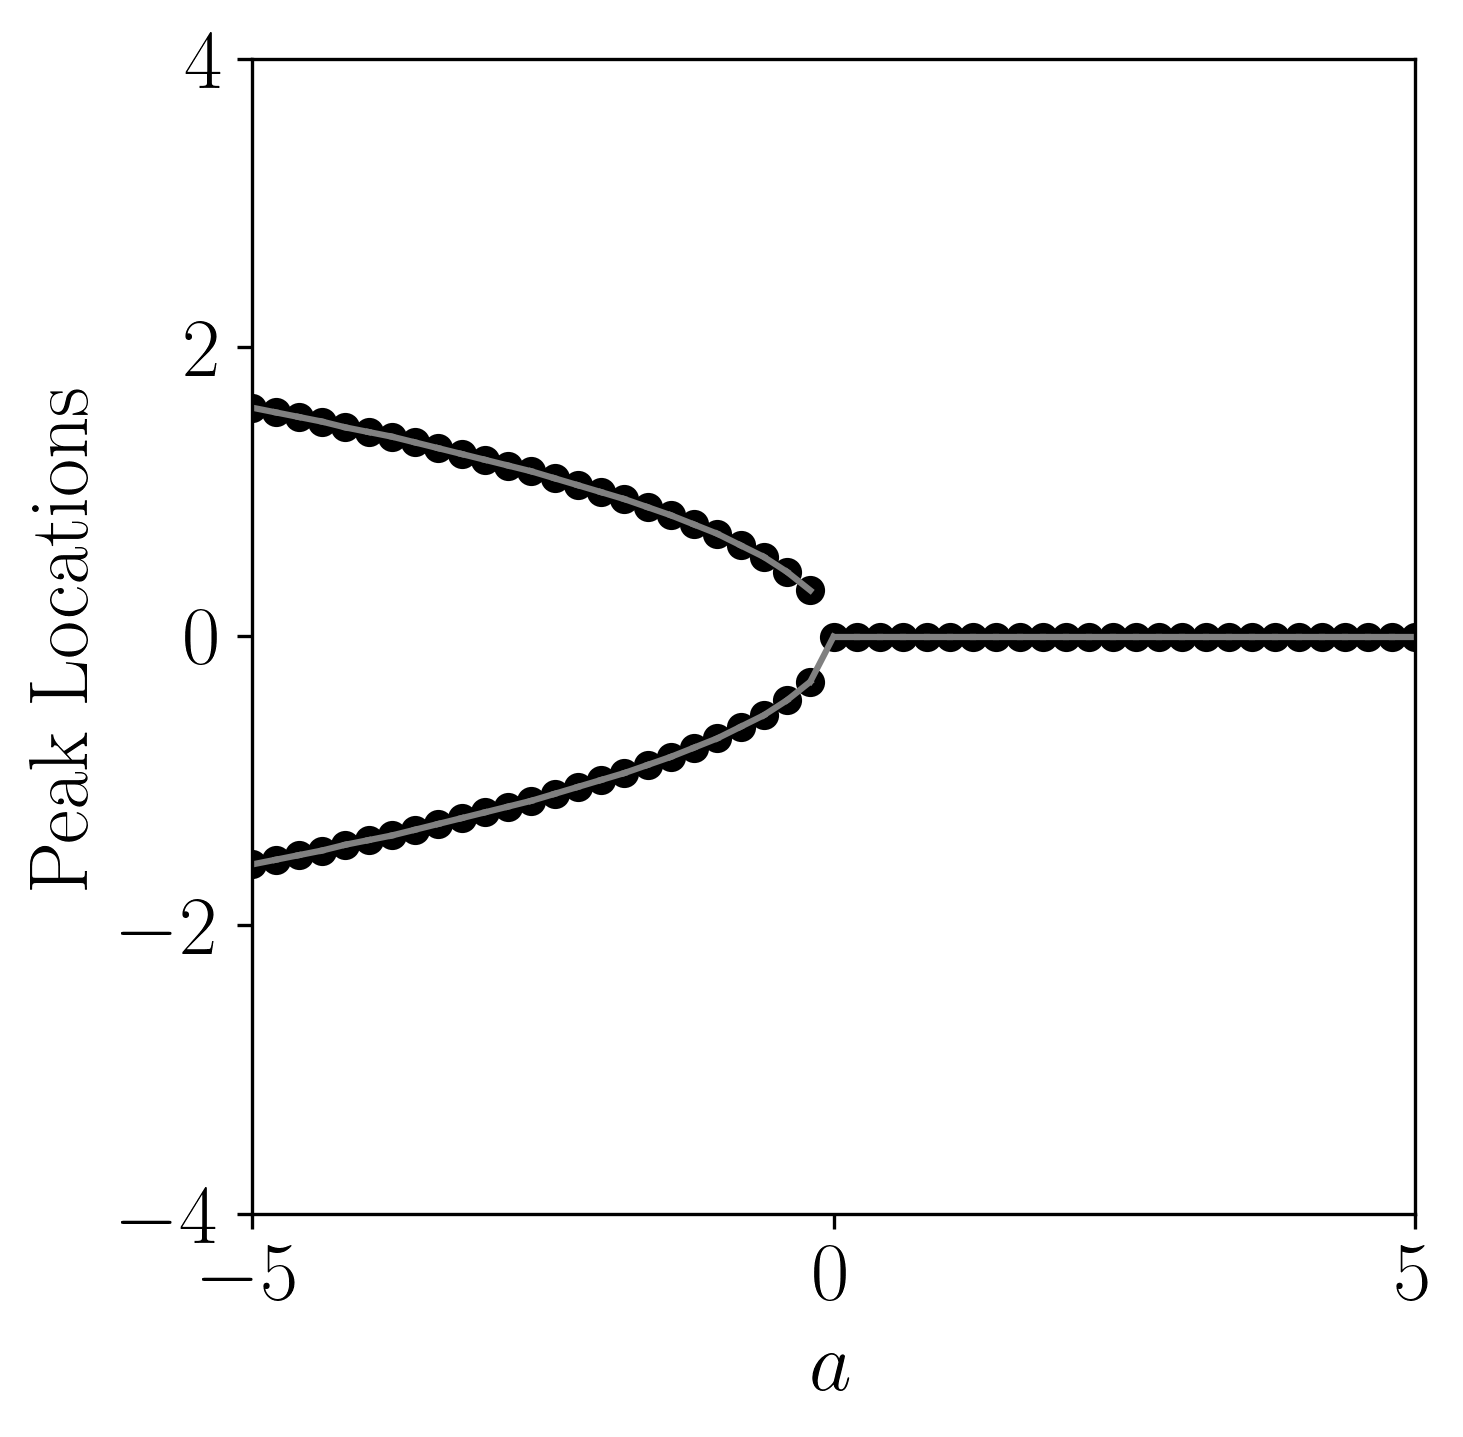

[array([-1.58158158,  1.58158158]),
 array([-1.54954955,  1.54954955]),
 array([-1.51751752,  1.51751752]),
 array([-1.48548549,  1.48548549]),
 array([-1.44544545,  1.44544545]),
 array([-1.41341341,  1.41341341]),
 array([-1.38138138,  1.38138138]),
 array([-1.34134134,  1.34134134]),
 array([-1.3013013,  1.3013013]),
 array([-1.26126126,  1.26126126]),
 array([-1.22122122,  1.22122122]),
 array([-1.18118118,  1.18118118]),
 array([-1.14114114,  1.14114114]),
 array([-1.09309309,  1.09309309]),
 array([-1.04504505,  1.04504505]),
 array([-0.996997,  0.996997]),
 array([-0.94894895,  0.94894895]),
 array([-0.89289289,  0.89289289]),
 array([-0.83683684,  0.83683684]),
 array([-0.77277277,  0.77277277]),
 array([-0.70870871,  0.70870871]),
 array([-0.62862863,  0.62862863]),
 array([-0.54854855,  0.54854855]),
 array([-0.44444444,  0.44444444]),
 array([-0.31631632,  0.31631632]),
 array([-0.004004]),
 array([-0.004004]),
 array([-0.004004]),
 array([-0.004004]),
 array([-0.004004]),
 

In [ ]:
peak_location_plot(PDFs, bifurcation_parameters=factors, x=X, plotting=True, title='Example')

# Mathematical Background Plots

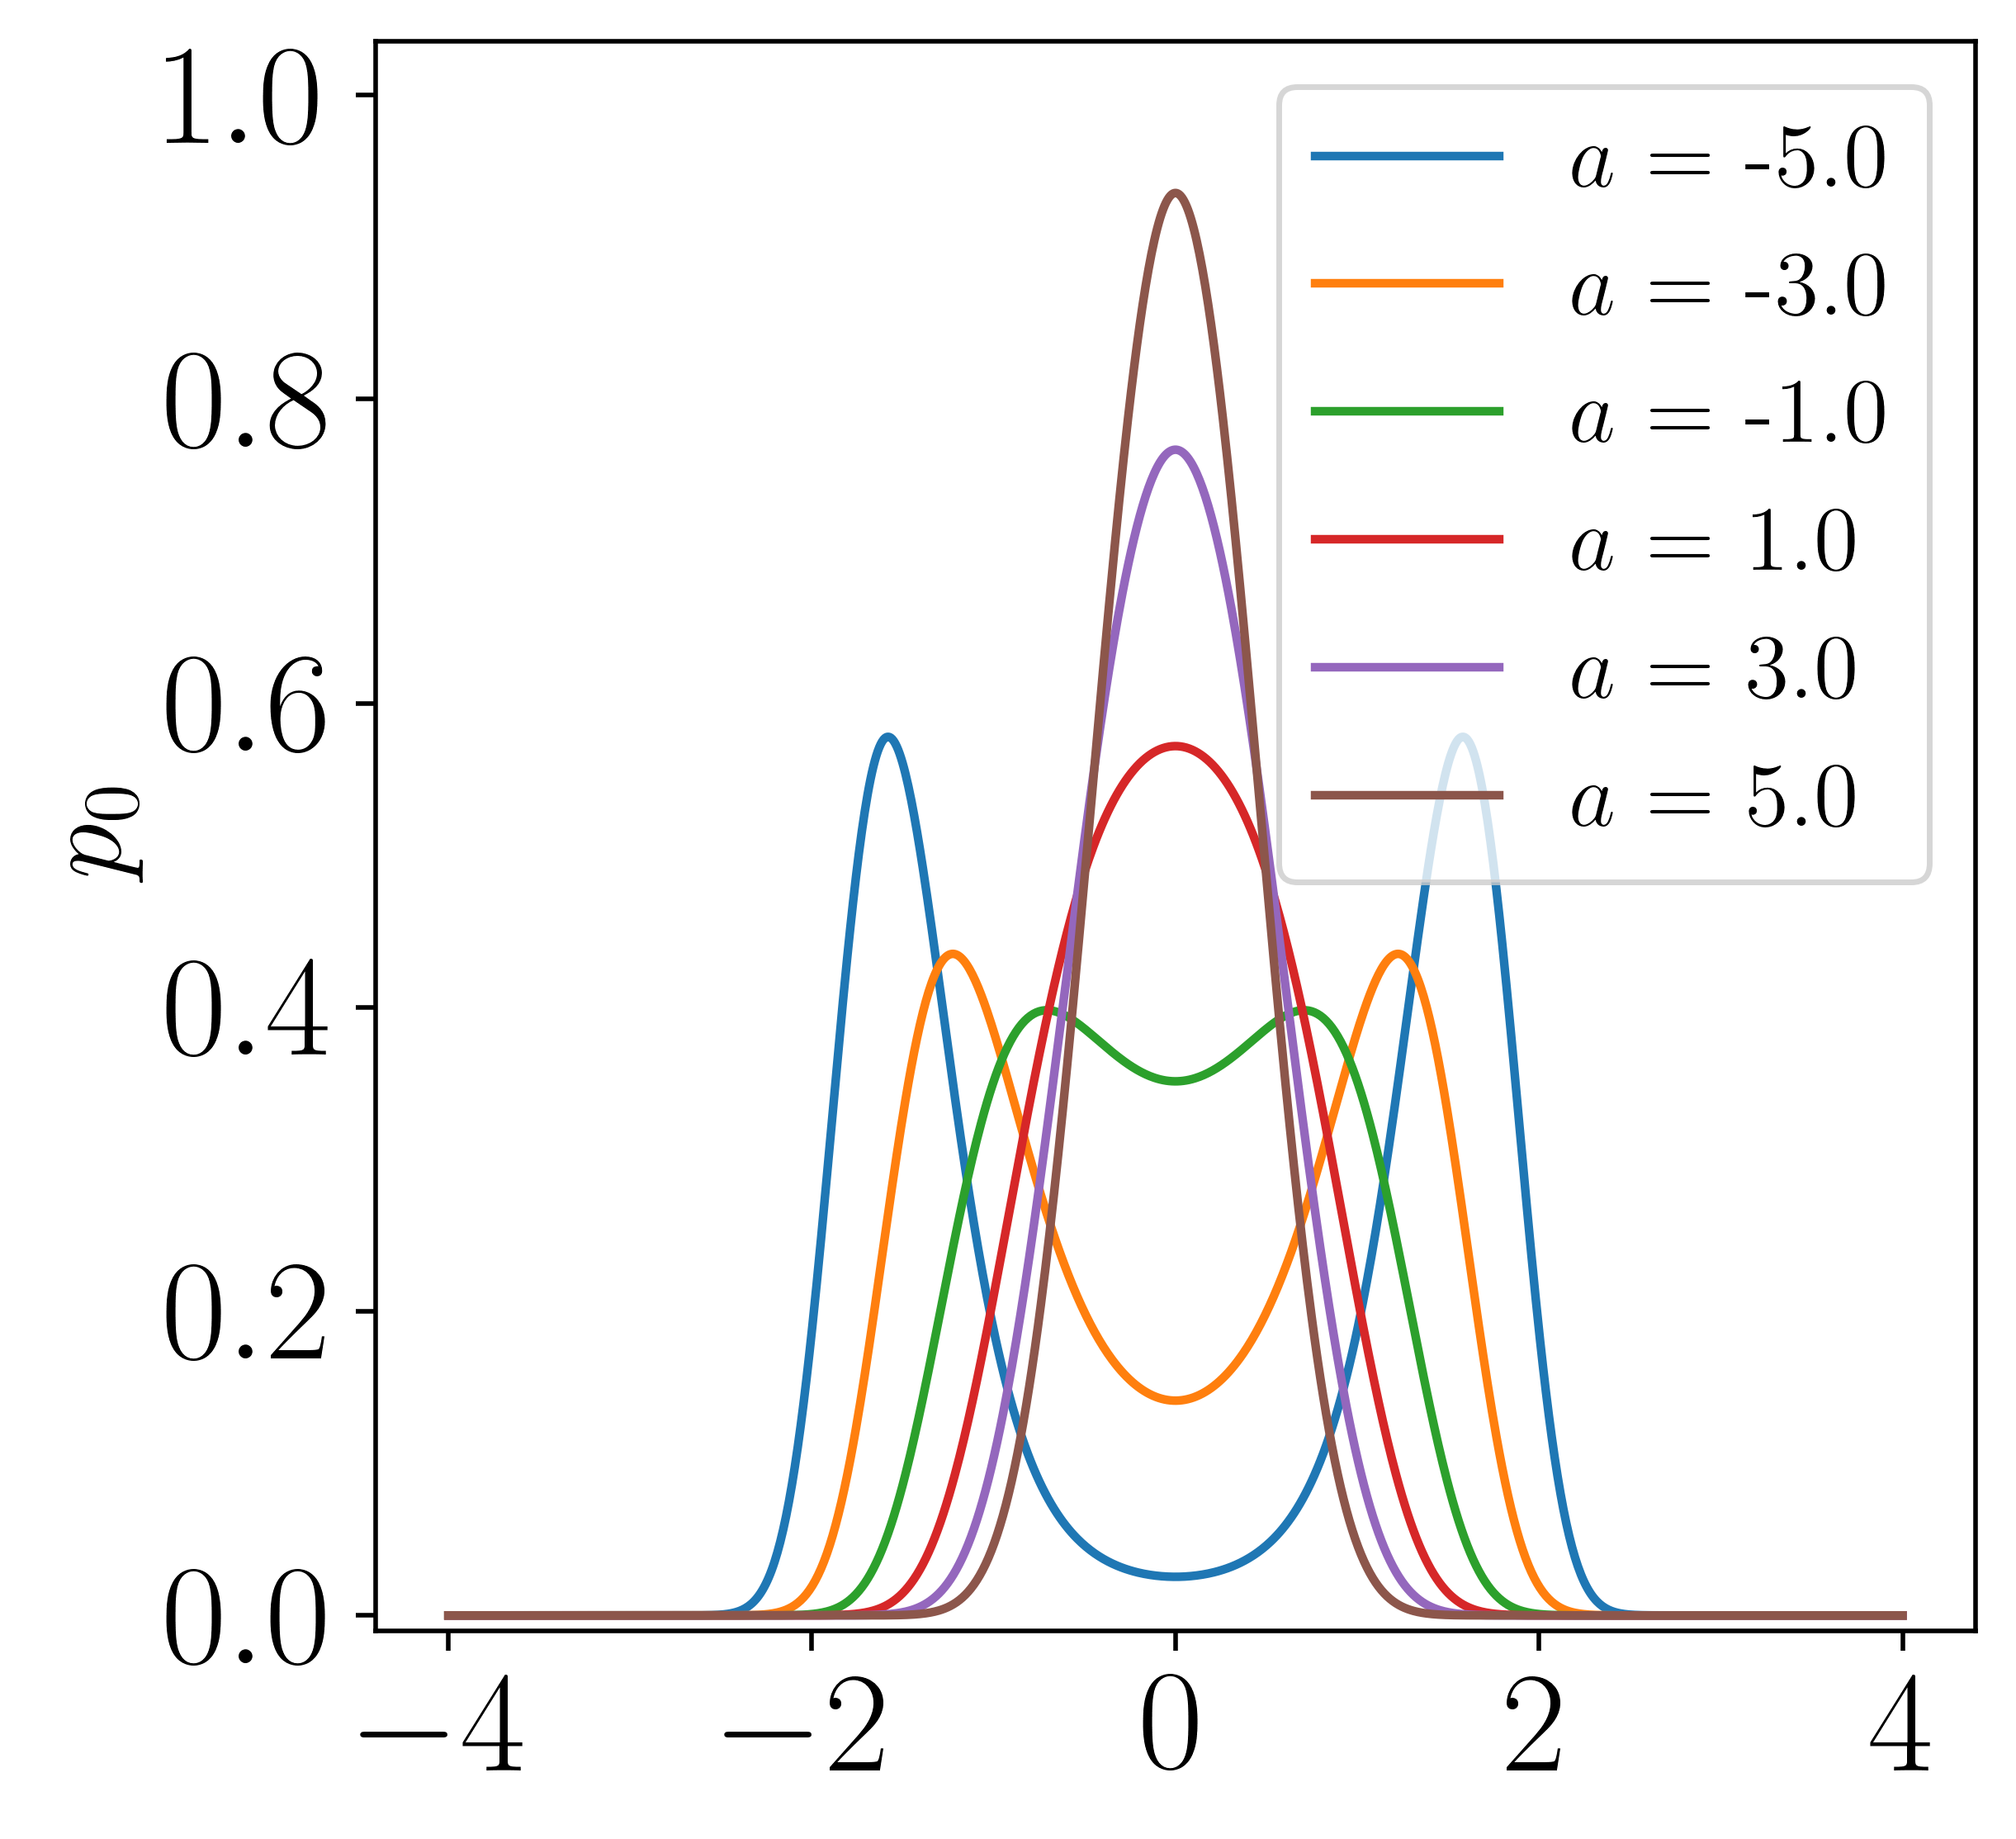

In [ ]:
plt.figure(figsize=(5, 5), dpi=500)
ymax = 0

index_rel_ints = [0, 10, 20, 30, 40, 50]

for i in index_rel_ints:
    plt.plot(X, PDFs[i], label=f'$a$ = {np.round(factors[i], 2)}')
    if np.max(PDFs[i]) > ymax:
        ymax = np.max(PDFs[i])


# plt.title(f'SIS LogOU, $R_0 = {R0}$', fontsize=30)
# plt.legend(loc='upper left', framealpha=0.8, fontsize=20)
plt.legend(loc='upper right', fontsize=16)

plt.ylabel(r'$p_0$', fontsize=20)
plt.xticks([-4, -2, 0, 2, 4], fontsize=25)
plt.yticks(fontsize=25)
# plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, ymax+0.1])

# plt.vlines(x=0.28571429, ymin=0, ymax=ymax, linestyles='dashed', colors='k')

# plt.savefig(f'SIS_LogOU_{R0}.png', dpi=150, bbox_inches='tight')

plt.show()

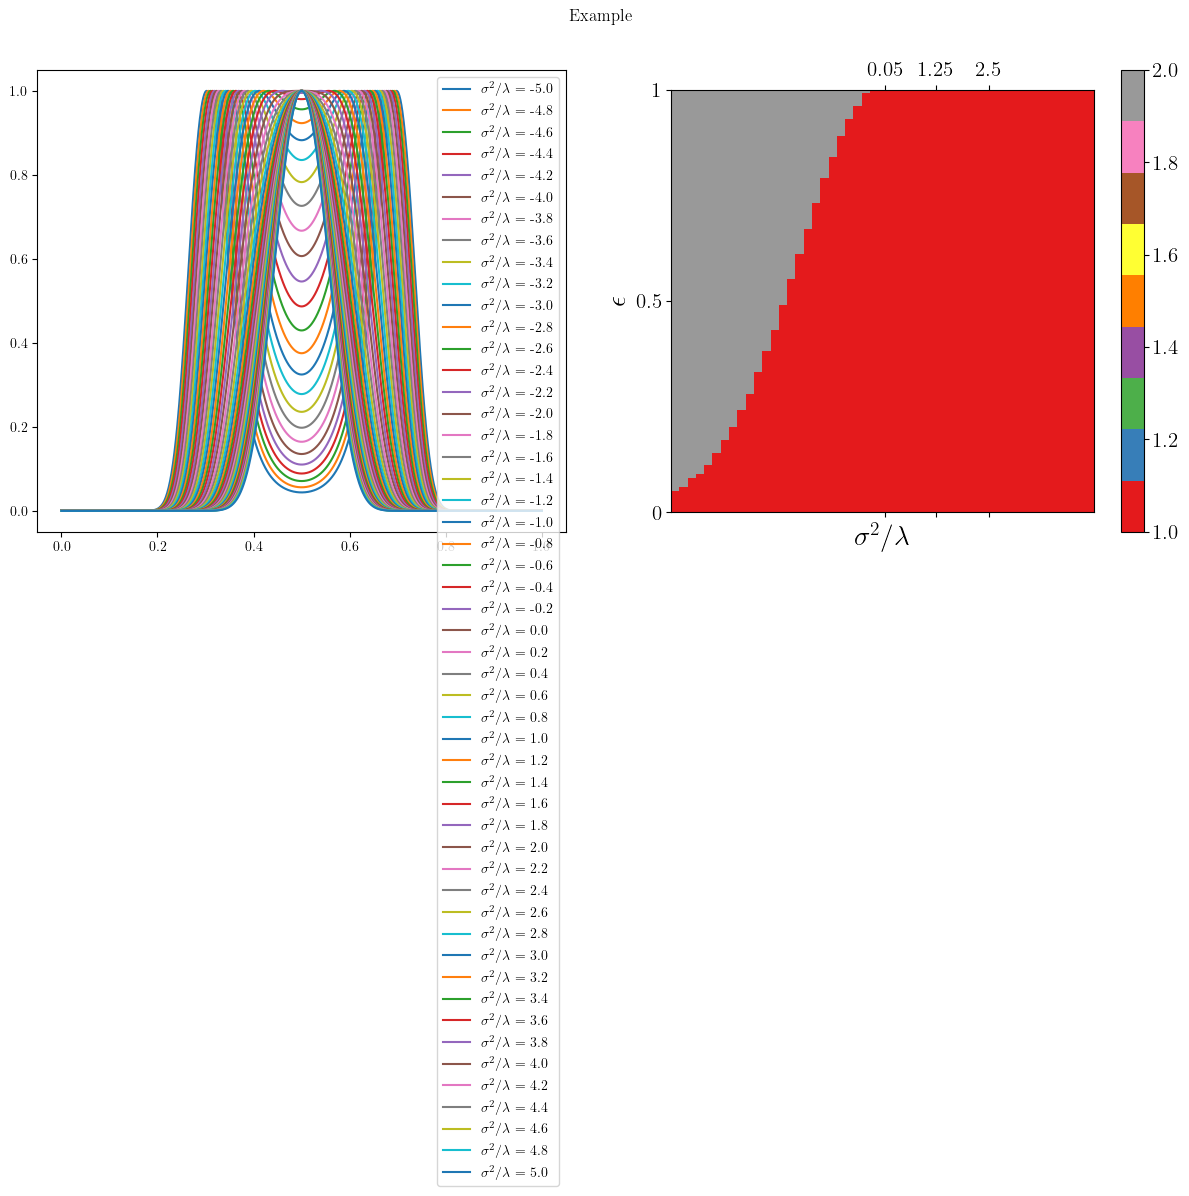

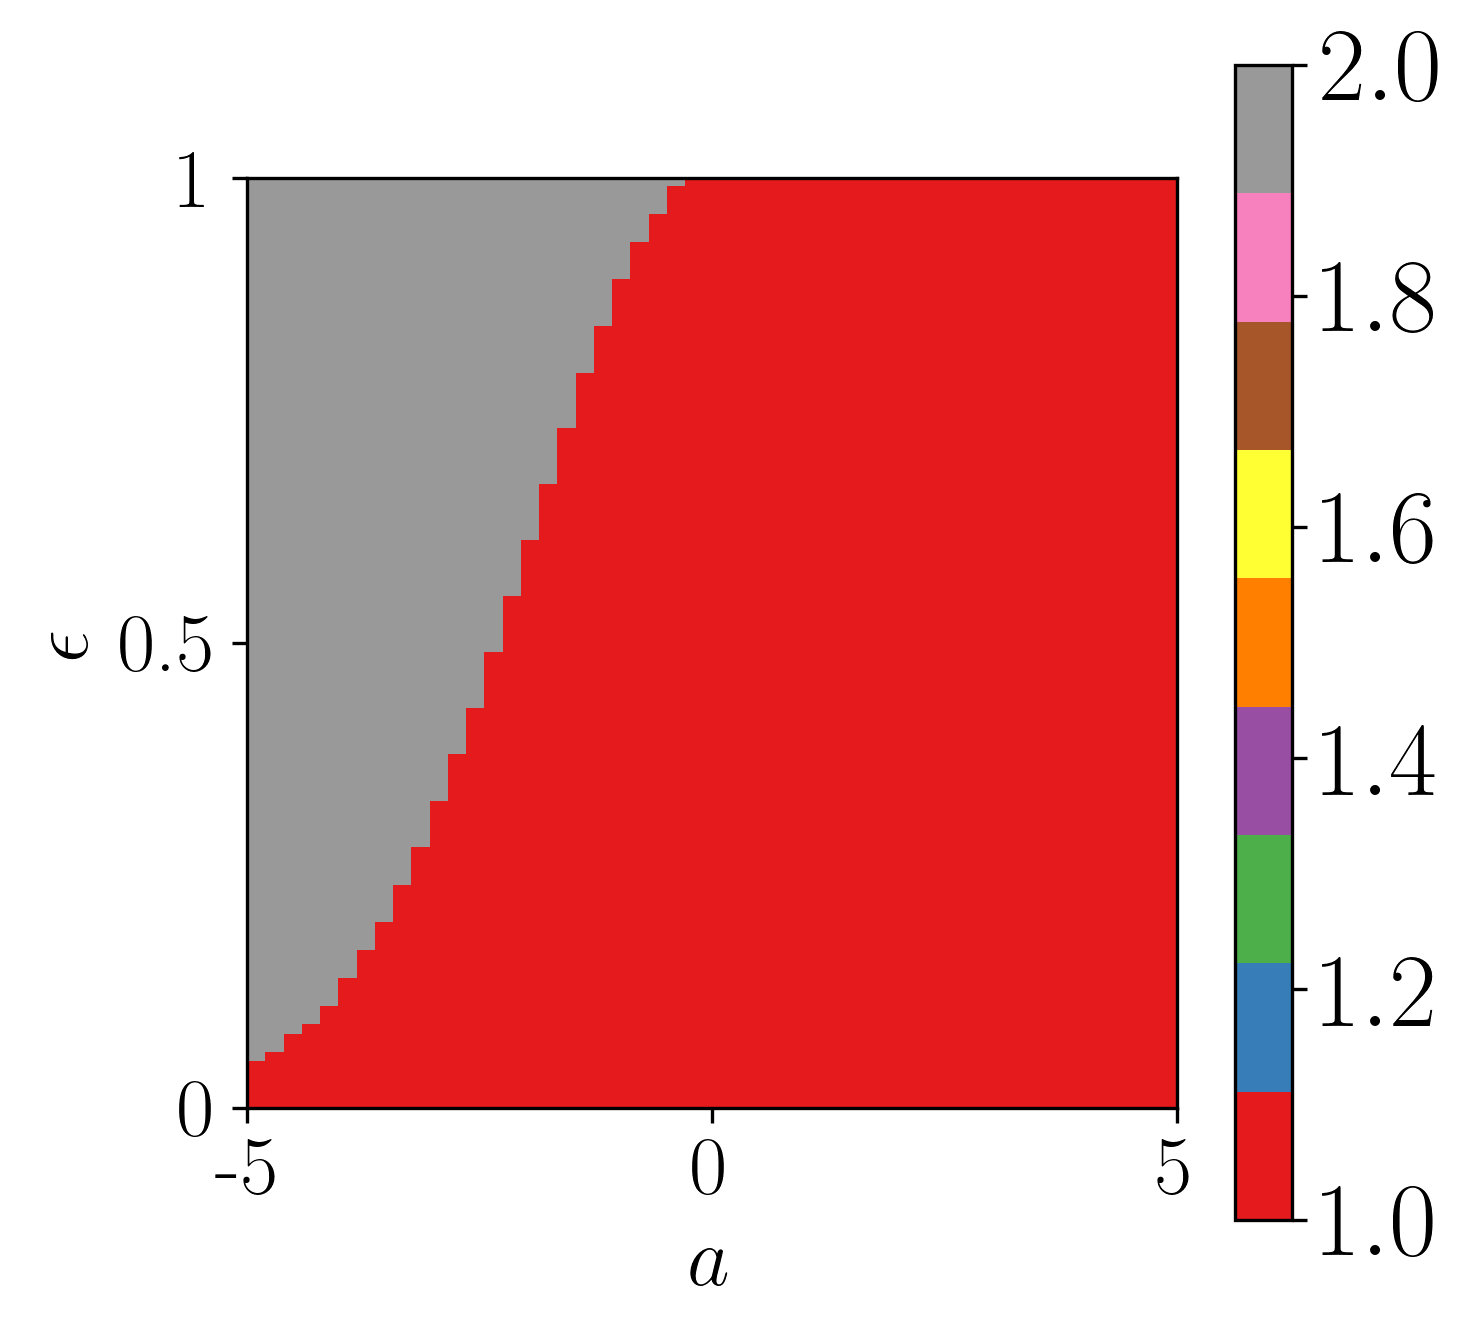

In [ ]:
M = analytical_homological_bifurcation_plot(PDFs, bifurcation_parameters=factors, dimensions=[0], filter=0.0, maxEps=0.99, numStops=100, plotting=True, title='Example', asp=10)